# $\mathrm{HONO_2}$ (Nitric Acid)

In [1]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 

using KernelFunctions
using ParameterHandling

In [2]:
include("./utils.jl")

predict_logσ_wΔ

# Loading Data

In [3]:
h5_path = "../../data/photolysis_data.h5" 
species = "HONO2" 
nice_name = "HONO₂"

λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

println("max λ: ", maximum(λs))
println("min λ: ", minimum(λs))

max λ: 439.81
min λ: 105.0


In [4]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [5]:
Δλ = 50 # nm for padding
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
# df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=0.0, λ_ub=1200.0)
println(nrow(df))
describe(df)

1042


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,λ,242.448,144.36,235.0,439.81,0,Float64
2,σ,3.22399e-18,1.6e-24,9.335e-20,1.77e-17,0,Float64
3,T,297.388,293.0,298.0,300.0,0,Float64
4,source_id,21.1209,1,24.0,40,0,Int64


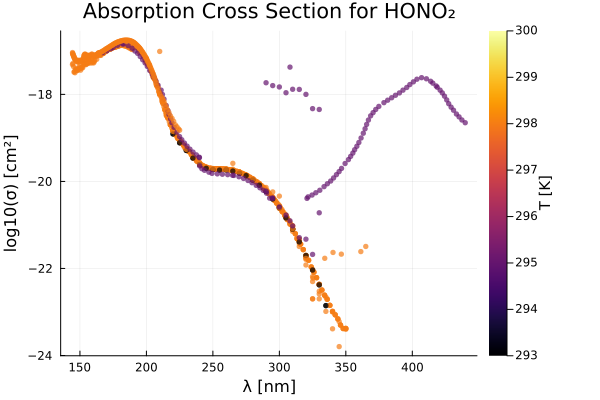

In [6]:
nskip = 1

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

savefig("O3_p2.png")

display(p2)

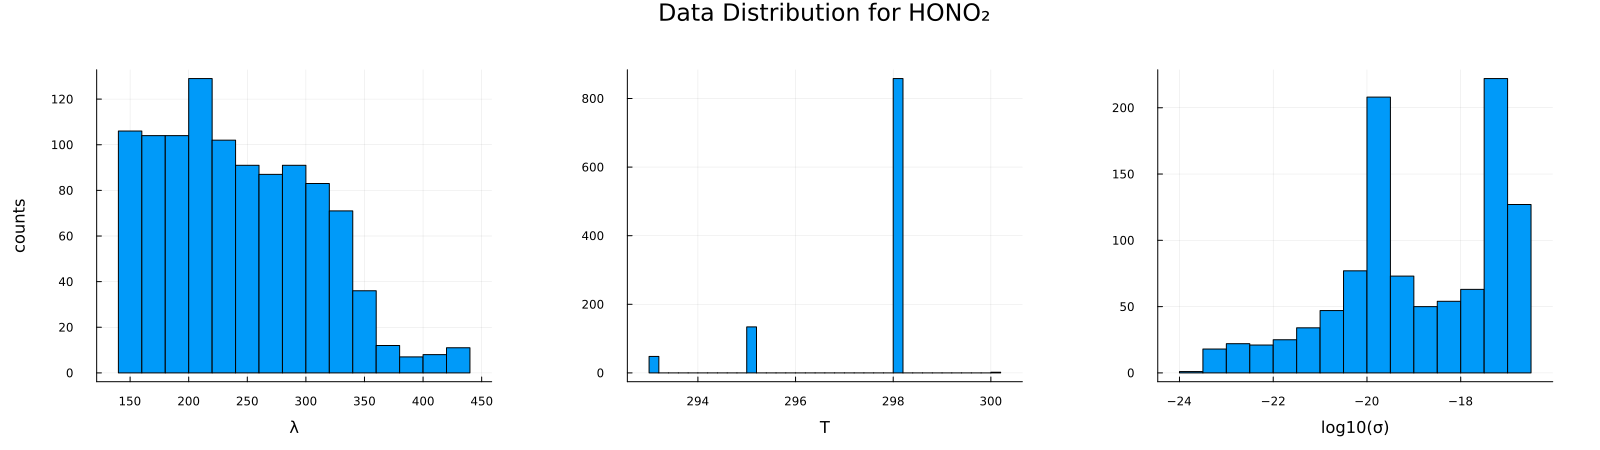

In [7]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="",)
p2 = histogram(df.T, xlabel="T", label="",)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="",)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450),  margin=10Plots.mm, plot_title="Data Distribution for $(nice_name)")

In [8]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

# Data Preprocessing

In [9]:
# deal with identical wavelength records 

gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

Row,λ,σ,T
,Float64,Float64,Float64
1,220.0,1.234e-19,293.0
2,225.0,7.73e-20,293.0
3,230.0,5.15e-20,293.0
4,235.0,3.44e-20,293.0
5,240.0,2.43e-20,293.0
6,245.0,2.0e-20,293.0
7,250.0,1.88e-20,293.0
8,255.0,1.82e-20,293.0
9,260.0,1.84e-20,293.0


In [25]:
# here is where we would do representative subsampling if there are too many records (> 2000) 
# λ_idxs = representative_rand_sample(df_unique.λ, 500, 1500)
# T_idxs = representative_rand_sample(df_unique.λ, 5, 1000)
# σ_idxs = representative_rand_sample(log10.(df_unique.σ), 500, 2000) 

# idxs_res = shuffle(unique(vcat(λ_idxs, T_idxs, σ_idxs)))
# df_sampled = df_unique[idxs_res, :]

# filter out the weird low temperature data
df_sampled = df_unique[df_unique.T .≥ 297.0, :]

max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

println(nrow(df_sampled))
describe(df_sampled)

546


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,λ,211.7,144.36,199.17,365.01,0,Float64
2,σ,5.08335e-18,3.8e-24,4.355e-18,1.77e-17,0,Float64
3,T,298.007,298.0,298.0,300.0,0,Float64


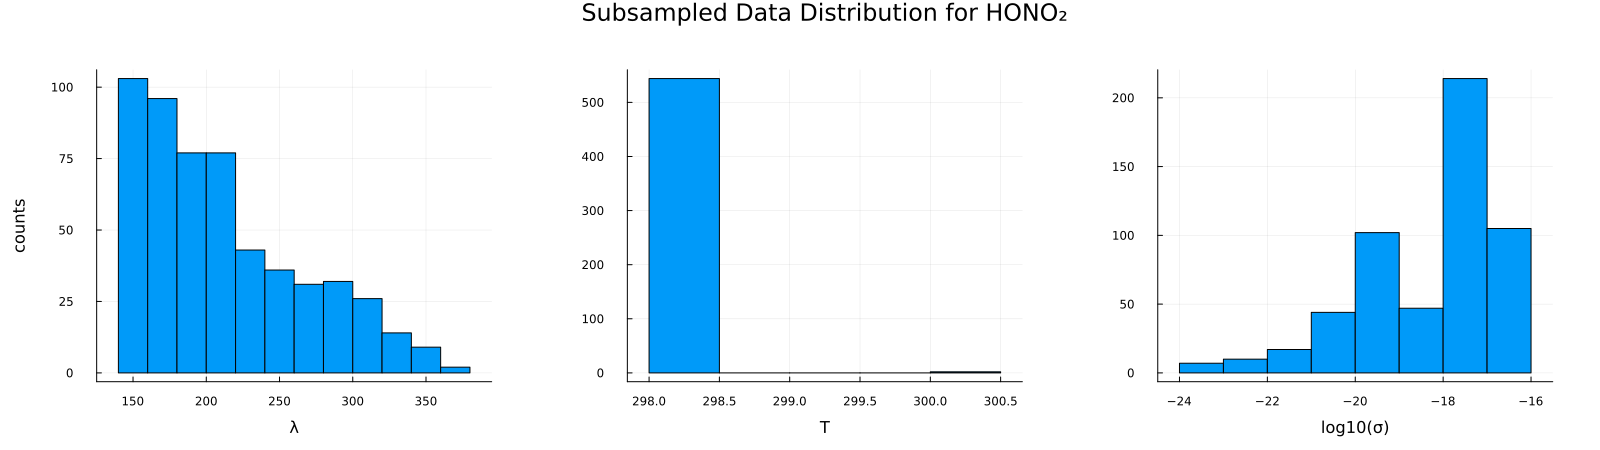

In [26]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(nice_name)")

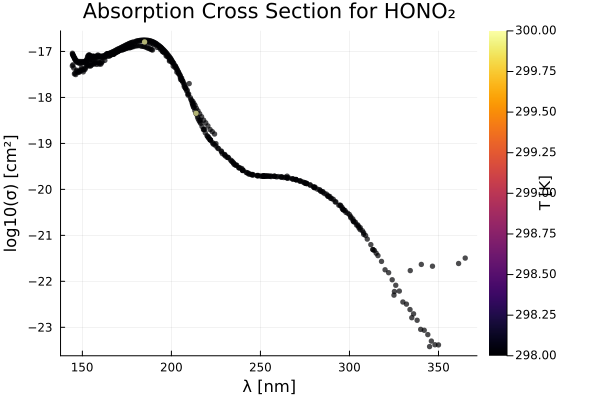

In [27]:
# visualize pre-processed data: 
p = scatter(
    df_sampled.λ,
    log10.(df_sampled.σ),
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

# GPR Fit

In [28]:
train_frac = 0.95
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

518


In [29]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = log10.(df_sampled.σ[idxs_train])
ytest = log10.(df_sampled.σ[idxs_test])

28-element Vector{Float64}:
 -16.92701525537207
 -16.779891911959943
 -17.205372555335494
 -19.302770657240284
 -19.703334809738468
 -17.281498311132726
 -20.419075024324382
 -18.292429823902065
 -19.473660722610155
 -16.99567862621736
 -20.899629454882437
 -17.58004425151024
 -17.013676222949236
   ⋮
 -19.66554624884907
 -17.059931986260647
 -17.185086818724926
 -19.166215625343522
 -20.97881070093006
 -18.34486156518862
 -16.99956592252068
 -17.3829996588791
 -17.621602099051863
 -17.246416941107093
 -16.79317412396815
 -17.071604147743287

In [30]:
# compute length scales
κ = 1
ℓ_λ = std(Xtrain.λ)/κ
ℓ_T = std(Xtrain.T)/κ

# compute variance parameters
SNR = 5 
σf² = var(ytrain)
σₙ² = (sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))


function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

LoadError: ArgumentError: Value (0.0) is not positive.

In [31]:
μ_init = -30.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(0.3745931637376083, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(4.335914142841761, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-0.3140474787970773, exp, 1.4901161193847656e-8)), 
  σ² = 0.10273220107138517, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [32]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

Iter     Function value   Gradient norm 
     0     1.891063e+02     2.154089e+02
 * time: 4.410743713378906e-5


[ Info: Training machine(GPR(μ = -30.0, …), …).


     1    -1.247136e+00     1.996011e+02
 * time: 0.3466949462890625
     2    -2.062564e+02     1.192248e+02
 * time: 0.4465610980987549
     3    -2.745923e+02     8.774553e+01
 * time: 0.5188078880310059
     4    -3.106020e+02     2.620217e+01
 * time: 0.6071679592132568
     5    -3.158663e+02     1.318829e+01
 * time: 0.7350950241088867
     6    -3.167684e+02     5.029369e+00
 * time: 0.7839291095733643
     7    -3.176470e+02     9.638815e+00
 * time: 0.858428955078125
     8    -3.185604e+02     5.510256e+00
 * time: 0.9360780715942383
     9    -3.186699e+02     3.155311e+00
 * time: 0.9912929534912109
    10    -3.187103e+02     2.084071e-01
 * time: 1.0383028984069824
    11    -3.187108e+02     3.154717e-02
 * time: 1.120589017868042
    12    -3.187108e+02     3.107675e-04
 * time: 1.2072710990905762
    13    -3.187108e+02     8.207419e-05
 * time: 1.2668709754943848
    14    -3.187108e+02     5.677796e-05
 * time: 1.3316218852996826
    15    -3.187108e+02     4.819773

trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @005 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @678 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [33]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [4.355324949065761, 3.6098488301981533, -0.3146463419062746, -4.281896464659405],
 minimum = -318.7107861912022,
 iterations = 1000,
 converged = false,)

In [34]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

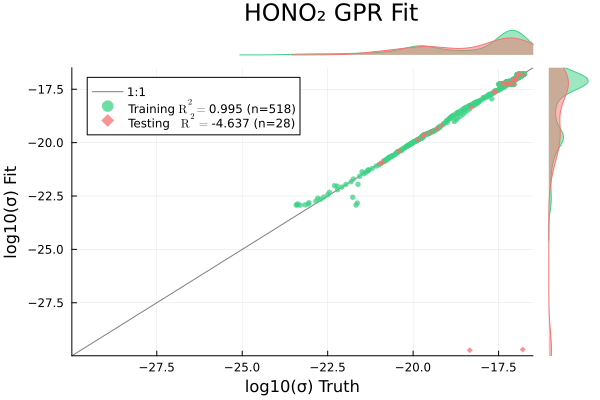

In [35]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit"
)

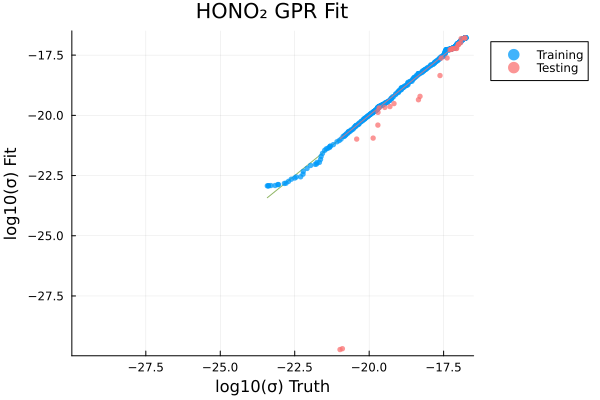

In [36]:
p = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit"
)


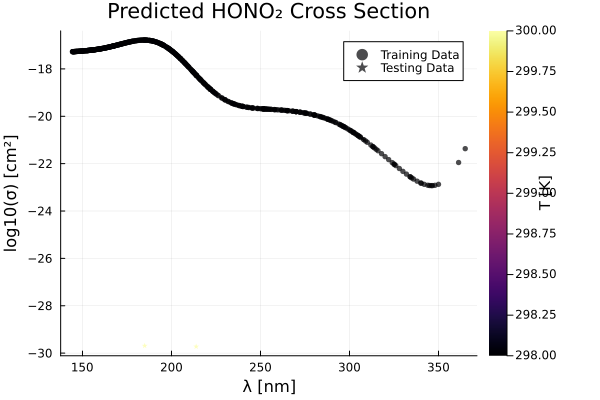

In [37]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)

194.249
365.01


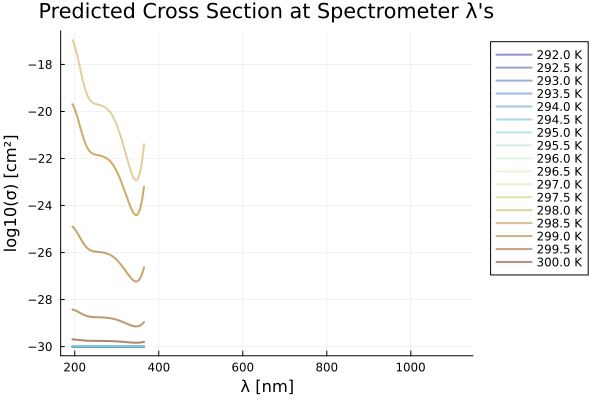

In [38]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_logσ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

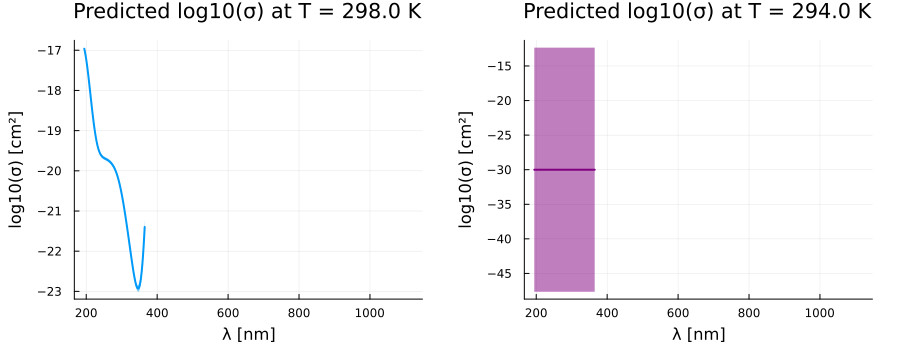

In [39]:
Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p1 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)

Tplot = 294.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p2 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 